In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import mrcfile
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import imageio.v2 as imageio  

ModuleNotFoundError: No module named 'mrcfile'

In [ ]:
#### Loading directories ####
main_dir=Path("/home/tharushi/Desktop/hackathon/10005")
false_positive_dir=main_dir/"ground_truth/false_positives"
particle_coord_dir=main_dir/"ground_truth/particle_coordinates"
micrograph_dir=main_dir/"micrographs"


In [ ]:
#### Building micrographs, particle csv,false_positive csv mapping ####
def extract_stack_id(filename):
    return filename.split("_2x")[0]


micrographs = {
    extract_stack_id(f.name): f
    for f in micrograph_dir.glob("*.mrc")   # or *.tif
}

false_positives = {
    extract_stack_id(f.name): f
    for f in false_positive_dir.glob("*.csv")
}

particle_coords = {
    extract_stack_id(f.name): f
    for f in particle_coord_dir.glob("*.csv")
}


valid_ids = (
    micrographs.keys()
    & false_positives.keys()
    & particle_coords.keys()
)
for stack_id in sorted(valid_ids):
    img_path = micrographs[stack_id]
    fp_csv = false_positives[stack_id]
    pc_csv = particle_coords[stack_id]

    print(f"\n{stack_id}")
    print("  Micrograph:", img_path.name)
    print("  False positives:", fp_csv.name)
    print("  Particles:", pc_csv.name)




stack_0002
  Micrograph: stack_0002_2x_SumCorr.mrc
  False positives: stack_0002_2x_SumCorr_false_positives.csv
  Particles: stack_0002_2x_SumCorr.csv

stack_0004
  Micrograph: stack_0004_2x_SumCorr.mrc
  False positives: stack_0004_2x_SumCorr_false_positives.csv
  Particles: stack_0004_2x_SumCorr.csv

stack_0005
  Micrograph: stack_0005_2x_SumCorr.mrc
  False positives: stack_0005_2x_SumCorr_false_positives.csv
  Particles: stack_0005_2x_SumCorr.csv

stack_0006
  Micrograph: stack_0006_2x_SumCorr.mrc
  False positives: stack_0006_2x_SumCorr_false_positives.csv
  Particles: stack_0006_2x_SumCorr.csv

stack_0010
  Micrograph: stack_0010_2x_SumCorr.mrc
  False positives: stack_0010_2x_SumCorr_false_positives.csv
  Particles: stack_0010_2x_SumCorr.csv

stack_0014
  Micrograph: stack_0014_2x_SumCorr.mrc
  False positives: stack_0014_2x_SumCorr_false_positives.csv
  Particles: stack_0014_2x_SumCorr.csv

stack_0016
  Micrograph: stack_0016_2x_SumCorr.mrc
  False positives: stack_0016_2x_Sum

/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


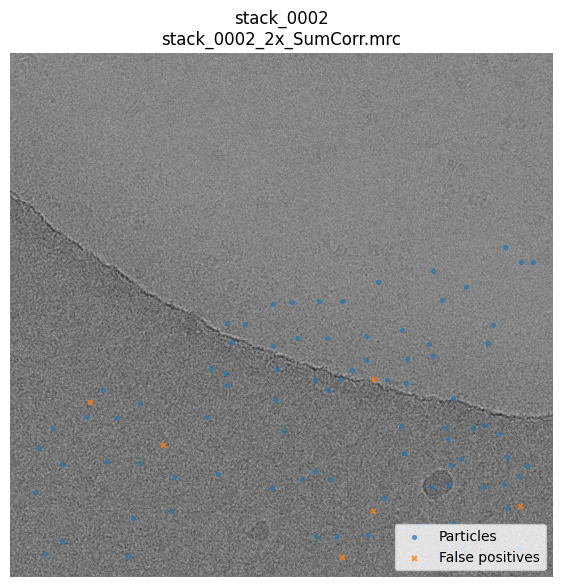

/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


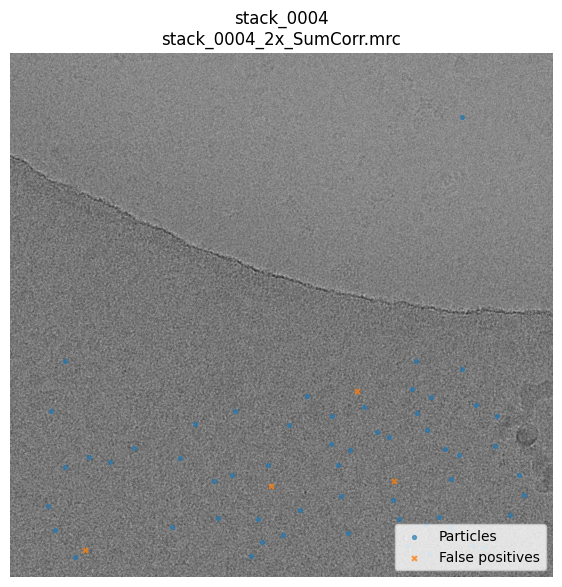

/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


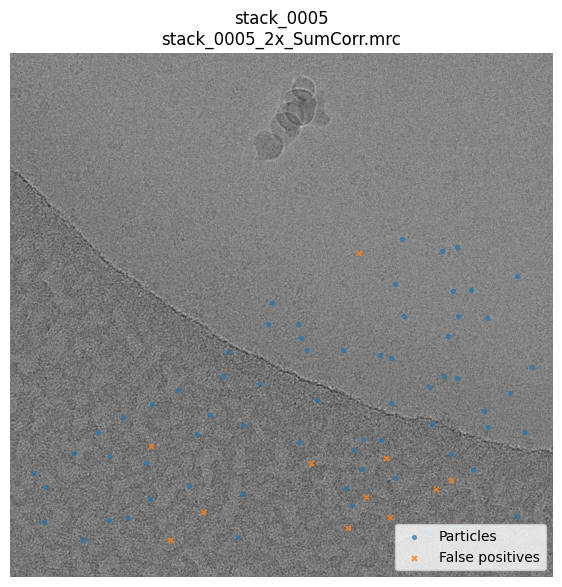

/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


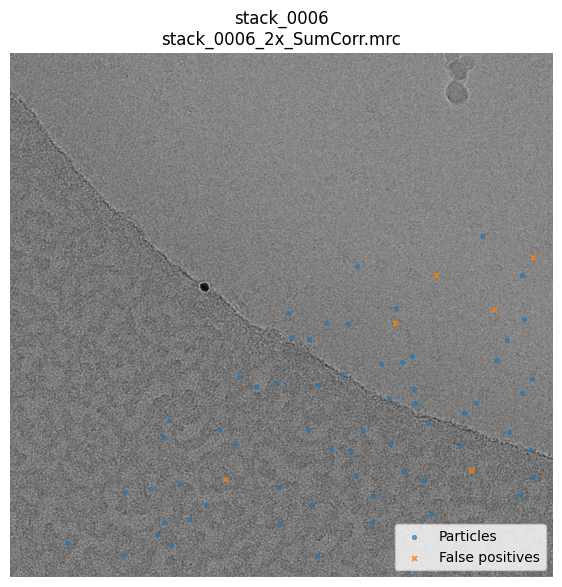

/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


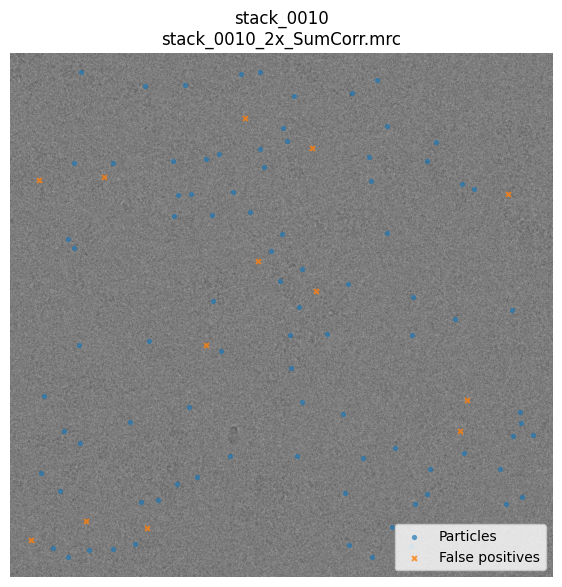

In [ ]:
#### Visualizing the overlay of False positives and particles ####

def load_micrograph(mrc_path):
    with mrcfile.open(mrc_path, permissive=True) as mrc:
        return np.array(mrc.data)

def read_xy_first_two_cols(csv_path):
    df = pd.read_csv(csv_path)
    x = pd.to_numeric(df.iloc[:, 0], errors="coerce").to_numpy()
    y = pd.to_numeric(df.iloc[:, 1], errors="coerce").to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    return x[mask], y[mask]

#  Overlay for 5 matched micrographs 
valid_ids_sorted = sorted(valid_ids)

for stack_id in valid_ids_sorted[:5]:
    img_path = micrographs[stack_id]
    fp_csv = false_positives[stack_id]
    pc_csv = particle_coords[stack_id]

    # load micrograph
    img = load_micrograph(img_path)

    # contrast enhancement for display
    vmin, vmax = np.percentile(img, [2, 98])

    # load coordinates (first two columns are X, Y)
    px, py = read_xy_first_two_cols(pc_csv)  # particles
    fx, fy = read_xy_first_two_cols(fp_csv)  # false positives

    # plot
    plt.figure(figsize=(7, 7))
    plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax, origin="upper")

    plt.scatter(px, py, s=8, marker="o", alpha=0.6, label="Particles")
    plt.scatter(fx, fy, s=12, marker="x", alpha=0.8, label="False positives")

    plt.title(f"{stack_id}\n{img_path.name}")
    plt.axis("off")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
#### Patch sizes and output directories ####
patch_size = 64      # we can try 64 / 96 / 128
half = patch_size // 2

out_root = main_dir / "patches"
out_particles = out_root / "particles"
out_falsepos = out_root / "false_positives"

out_particles.mkdir(parents=True, exist_ok=True)
out_falsepos.mkdir(parents=True, exist_ok=True)

print("Saving to:", out_root)

Saving to: /home/tharushi/Desktop/hackathon/10005/patches


In [ ]:
### Cropping and ormalization helper functions ####
def crop_patch(img, x, y, patch_size):
    """
    Crop patch centered at (x,y). Returns None if it would go out of bounds.
    """
    H, W = img.shape
    half = patch_size // 2

    xc = int(round(x))
    yc = int(round(y))

    x0, x1 = xc - half, xc + half
    y0, y1 = yc - half, yc + half

    if x0 < 0 or y0 < 0 or x1 > W or y1 > H:
        return None

    return img[y0:y1, x0:x1]


def patch_to_uint8(patch):
    """
    Convert float/int patch -> uint8 PNG-friendly image using percentile contrast.
    """
    vmin, vmax = np.percentile(patch, [2, 98])
    patch = np.clip(patch, vmin, vmax)
    patch = (patch - vmin) / (vmax - vmin + 1e-8)
    return (patch * 255).astype(np.uint8)


/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


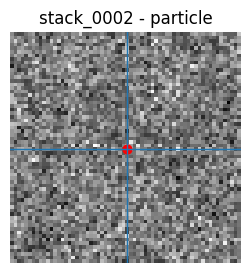

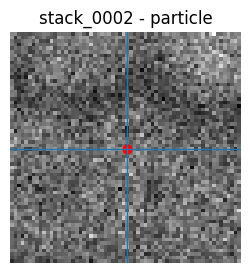

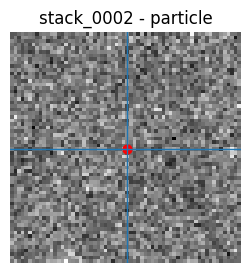

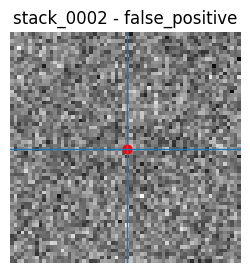

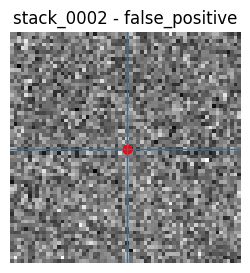

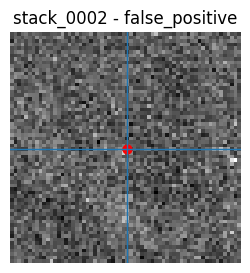

In [44]:
test_id = valid_ids_sorted[0]  # first matched stack
img_path = micrographs[test_id]
fp_csv = false_positives[test_id]
pc_csv = particle_coords[test_id]

img = load_micrograph(img_path)
px, py = read_xy_first_two_cols(pc_csv)
fx, fy = read_xy_first_two_cols(fp_csv)

# show 3 particle patches + 3 false-positive patches
import matplotlib.pyplot as plt

for (label, xs, ys) in [("particle", px, py), ("false_positive", fx, fy)]:
    shown = 0
    for i in range(len(xs)):
        patch = crop_patch(img, xs[i], ys[i], patch_size)
        if patch is None:
            continue
        h, w = patch.shape[0]//2, patch.shape[1]//2
        plt.figure(figsize=(3, 3))
        plt.imshow(patch, cmap="gray")
        plt.scatter([w], [h], c="red", s=40)  # center dot
        plt.axhline(h, linewidth=1)
        plt.axvline(w, linewidth=1)
        plt.title(f"{test_id} - {label}")
        plt.axis("off")
        plt.show()


        shown += 1
        if shown == 3:
            break


In [ ]:
#### Extract and save pathes for all micrgraphs ####

metadata_rows = []

for stack_id in valid_ids_sorted:
    img_path = micrographs[stack_id]
    fp_csv = false_positives[stack_id]
    pc_csv = particle_coords[stack_id]

    img = load_micrograph(img_path)
    H, W = img.shape

    px, py = read_xy_first_two_cols(pc_csv)
    fx, fy = read_xy_first_two_cols(fp_csv)

    # ---- Particles ----
    p_count = 0
    for i, (x, y) in enumerate(zip(px, py)):
        patch = crop_patch(img, x, y, patch_size)
        if patch is None:
            continue

        out_path = out_particles / f"{stack_id}_particle_{p_count:06d}.png"
        imageio.imwrite(out_path, patch_to_uint8(patch))

        metadata_rows.append({
            "stack_id": stack_id,
            "micrograph": img_path.name,
            "source_csv": pc_csv.name,
            "label": "particle",
            "x": float(x),
            "y": float(y),
            "patch_path": str(out_path),
            "patch_size": patch_size
        })
        p_count += 1

    # ---- False positives ----
    f_count = 0
    for i, (x, y) in enumerate(zip(fx, fy)):
        patch = crop_patch(img, x, y, patch_size)
        if patch is None:
            continue

        out_path = out_falsepos / f"{stack_id}_falsepos_{f_count:06d}.png"
        imageio.imwrite(out_path, patch_to_uint8(patch))

        metadata_rows.append({
            "stack_id": stack_id,
            "micrograph": img_path.name,
            "source_csv": fp_csv.name,
            "label": "false_positive",
            "x": float(x),
            "y": float(y),
            "patch_path": str(out_path),
            "patch_size": patch_size
        })
        f_count += 1

print(" Finished extracting patches.")
print("Total patches:", len(metadata_rows))


/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
/home/tharushi/anaconda3/envs/hackathon/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file,

 Finished extracting patches.
Total patches: 5831


In [49]:
meta_df = pd.DataFrame(metadata_rows)
meta_path = out_root / "patch_metadata.csv"
meta_df.to_csv(meta_path, index=False)

print("Saved metadata to:", meta_path)
print(meta_df["label"].value_counts())


Saved metadata to: /home/tharushi/Desktop/hackathon/10005/patches/patch_metadata.csv
label
particle          5374
false_positive     457
Name: count, dtype: int64
